# Tour of mosquito collection sites

In this notebook we'll take a virtual tour of the locations where mosquitoes contributed to Ag1000G phase 3 were collected. We'll plot some maps to see the collection sites in their geographical context. For extra interest, we'll also add some other geographical data to the maps, such as [ecosystem classifications](http://www.aag.org/cs/publications/special/map_african_ecosystems) and data from the [Malaria Atlas Project](https://malariaatlas.org/explorer/#/). 

As always, this notebook is executable, which means you can run it for yourself by clicking the launch icon (@@) and selecting one of the cloud computing services available. 

## Setup

To load geographical data and plot maps, we'll need the [cartopy](https://scitools.org.uk/cartopy/docs/latest/) and [rasterio](https://rasterio.readthedocs.io/en/latest/) packages. Installing these packages can be a bit fiddly. If you're running this on Google Colab, the code below should do it. If you're running on MyBinder then these should already be installed, and you can comment out the code below.

In [1]:
!apt-get -q install gdal-bin libgdal-dev python3-cartopy
!pip uninstall -q -y shapely  # required on colab due to some incompatibility issues
!pip install --upgrade -q cartopy rasterio

Reading package lists...
Building dependency tree...
Reading state information...
gdal-bin is already the newest version (2.2.3+dfsg-2).
The following additional packages will be installed:
  default-libmysqlclient-dev libarmadillo-dev libarpack2-dev libblas-dev
  libblas3 libdap-dev libdapserver7v5 libepsilon-dev libfreexl-dev libfyba-dev
  libgeos-dev libgeotiff-dev libgif-dev libhdf4-alt-dev libjson-c-dev
  libkml-dev libkmlconvenience1 libkmlregionator1 libkmlxsd1 libminizip-dev
  libmysqlclient-dev libnetcdf-dev libogdi3.2-dev libopenjp2-7-dev
  libpoppler-dev libpoppler-private-dev libpq-dev libproj-dev libqhull-dev
  libqhull-r7 libspatialite-dev libsqlite3-dev libsuperlu-dev liburiparser-dev
  libwebp-dev libxerces-c-dev python3-pkg-resources python3-pyshp
  python3-shapely python3-six unixodbc-dev
Suggested packages:
  libitpp-dev liblapack-doc libgdal-doc libgeotiff-epsg netcdf-bin netcdf-doc
  postgresql-doc-10 proj-bin sqlite3-doc libsuperlu-doc libxerces-c-doc
  python3-ma

We'll also need the [malariagen_data](https://github.com/malariagen/malariagen-data-python) package to load data from Ag1000G:

In [2]:
!pip install -q malariagen_data 

     |████████████████████████████████| 112kB 4.1MB/s 
     |████████████████████████████████| 133kB 6.1MB/s 
     |████████████████████████████████| 5.8MB 5.9MB/s 
     |████████████████████████████████| 1.3MB 52.0MB/s 
     |████████████████████████████████| 296kB 55.5MB/s 
     |████████████████████████████████| 143kB 39.0MB/s 


In [1]:
# setup access to MalariaGEN data via Google Cloud
import malariagen_data
ag3 = malariagen_data.Ag3("gs://vo_agam_release/")

To plot the extra geographical data, we'll need to download some files. 

The ecosystem classifications in full resolution are available from the [USGS website](http://rmgsc.cr.usgs.gov/outgoing/ecosystems/AfricaData/), but these are large files and higher resolution than we need. For convenience we've precomputed a downsampled version of these data, let's download it.  

In [2]:
!wget --no-clobber https://storage.googleapis.com/vo_agam_release/reference/af_labeled_ecosys/Africa_IVC_20130316_final_MG_5pc.tif
!wget --no-clobber https://storage.googleapis.com/vo_agam_release/reference/af_labeled_ecosys/Africa_IVC_20130316_final_MG.tif.vat.csv

File ‘Africa_IVC_20130316_final_MG_5pc.tif’ already there; not retrieving.

File ‘Africa_IVC_20130316_final_MG.tif.vat.csv’ already there; not retrieving.



Data from the Malaria Atlas Project can be downloaded from their [data explorer site](https://malariaatlas.org/explorer/). Let's download the most recent ITN coverage model.

In [3]:
!wget --no-clobber -O 2020_Africa_ITN_Use.zip "https://malariaatlas.org/geoserver/Explorer/ows?service=CSW&version=2.0.1&request=DirectDownload&ResourceId=Explorer:2020_Africa_ITN_Use"
!unzip -n -d 2020_Africa_ITN_Use 2020_Africa_ITN_Use.zip

File ‘2020_Africa_ITN_Use.zip’ already there; not retrieving.
Archive:  2020_Africa_ITN_Use.zip


Now let's define some functions for loading the map data and plotting a map, with support for different background options.

In [4]:
from functools import lru_cache
import pandas as pd
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import rasterio
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io.img_tiles import OSM, GoogleTiles

In [5]:
# setup some geographical projections
crs_lonlat = ccrs.PlateCarree()
crs_mercator = ccrs.Mercator()
crs_laea = ccrs.LambertAzimuthalEqualArea()

In [6]:
@lru_cache(maxsize=None)
def load_ecosystems():
    """Load the African ecosystems data."""

    # build a matplotlib colour map from the colour table
    df_colors = pd.read_csv('Africa_IVC_20130316_final_MG.tif.vat.csv').set_index('Value')
    colors = np.zeros((df_colors.index.max() + 1, 3), dtype=float)
    for v, (r, g, b) in df_colors[['Red', 'Green', 'Blue']].iterrows():
        colors[int(v)] = r, g, b
    # fix the zero colour to be white
    colors[0] = 1, 1, 1
    cmap = mpl.colors.ListedColormap(colors)

    # load the image data
    image = rasterio.open("Africa_IVC_20130316_final_MG_5pc.tif")
    image_data = image.read(1)
    image_data = np.ma.masked_where(image_data < 0, image_data)  

    # determine image extent 
    extent = (
        image.bounds.left, 
        image.bounds.right,
        image.bounds.bottom,
        image.bounds.top
    )         

    return image_data, cmap, extent, crs_lonlat


In [7]:
@lru_cache(maxsize=None)
def load_itn_coverage(year):
    """Load ITN coverage data for a given year."""
    
    image = rasterio.open(f"2020_Africa_ITN_Use/2020_GBD2021_Africa_ITN_Coverage_{year}.tif")
    image_data = image.read(1)
    image_data = np.ma.masked_where(image_data <= 0, image_data)
    cmap = "RdYlGn"
    extent = (
        image.bounds.left, 
        image.bounds.right,
        image.bounds.bottom,
        image.bounds.top
    )
    return image_data, cmap, extent, crs_lonlat


In [56]:
def plot_map(extent=None, sample_sets="v3_wild", background='osm', bgzoom=3, bgstyle='street', 
             bgyear=2019, ax=None, figsize=(7, 7), gridlines=15,
             plot_kws=None):
    """Plot a map."""

    # normalise background parameter to lower case
    background = background.lower()

    if extent is None:
        # default to the whole of Africa
        extent = -26, 64, -35, 38

    # decide what projection to use
    if background in {'osm', 'google'}:
        # these backgrounds use Mercator projection and look best in their
        # native projection
        projection = crs_mercator
    else:
        # other backgrounds use Plate Carree
        projection = crs_lonlat
        
    # create a figure and axes to plot on
    if ax is None:
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(111, projection=projection)

    # set the extent of the map
    ax.set_extent(extent, crs=crs_lonlat)

    # plot the background image

    if background == 'osm':
        # use OpenStreetMap as background
        imagery = OSM()
        ax.add_image(imagery, bgzoom)

    elif background == 'google':
        # use Google Maps as background
        imagery = GoogleTiles(style=bgstyle)
        ax.add_image(imagery, bgzoom)

    elif background == 'ecosystems':
        # use African Ecosystems as background
        image_data, image_cmap, image_extent, image_crs = load_ecosystems()
        ax.imshow(image_data, cmap=image_cmap, 
                  interpolation='nearest', extent=image_extent,
                  origin='upper', transform=image_crs)
        
    elif background == 'itn_coverage':
        # use ITN coverage as background
        image_data, image_cmap, image_extent, image_crs = load_itn_coverage(bgyear)
        ax.imshow(image_data, cmap=image_cmap, 
                  interpolation='nearest', extent=image_extent,
                  origin='upper', transform=image_crs)

    if background in {"ecosystems", "itn_coverage"}:
        # add useful features
        ax.coastlines(resolution='50m', linewidth=1)
        ax.add_feature(cfeature.BORDERS, linewidth=1)

    # draw gridlines
    if gridlines:
        gl = ax.gridlines(crs=crs_lonlat, 
                          xlocs=np.arange(-180, 180, gridlines), 
                          ylocs=np.arange(-180, 180, gridlines), 
                          draw_labels=True)
        gl.top_labels = None
        gl.right_labels = None

    # plot sampling sites
    if sample_sets is not None:
        df_samples = ag3.sample_metadata(sample_sets=sample_sets)
        df_sites = df_samples[['location', 'longitude', 'latitude']].drop_duplicates()
        x = df_sites['longitude']
        y = df_sites['latitude']
        if plot_kws is None:
            plot_kws = dict()
        plot_kws.setdefault('marker', '+')
        plot_kws.setdefault('linestyle', ' ')
        plot_kws.setdefault('color', 'k')
        plot_kws.setdefault('markersize', 6)
        plot_kws.setdefault('markeredgewidth', 1)
        ax.plot(x, y, transform=crs_lonlat, **plot_kws)

    

Let's try out the map plotting function, with the different backgound options...

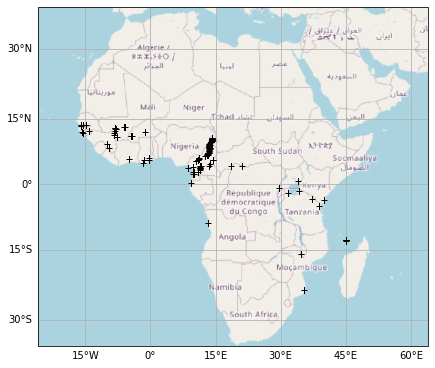

In [57]:
plot_map(background='osm', bgzoom=3)

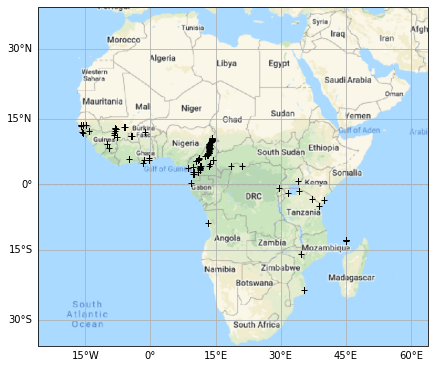

In [58]:
plot_map(background='google', bgzoom=3, bgstyle='street')

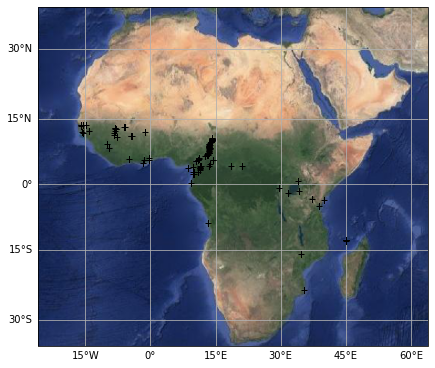

In [59]:
plot_map(background='google', bgzoom=3, bgstyle='satellite')

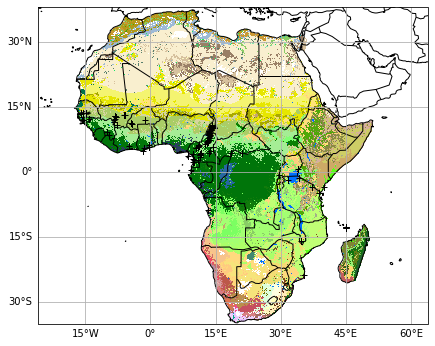

In [60]:
plot_map(background='ecosystems')

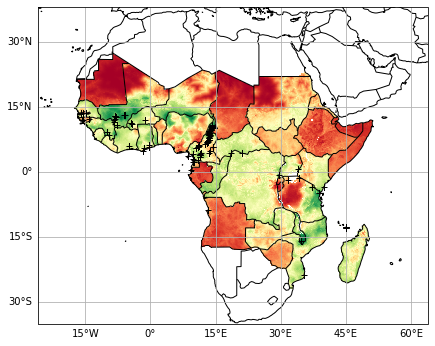

In [61]:
plot_map(background='itn_coverage', bgyear=2019)

OK, now let's zoom into some of the different sampling locations, starting with locations that were newly represented in Ag1000G phase 3.

## Mozambique


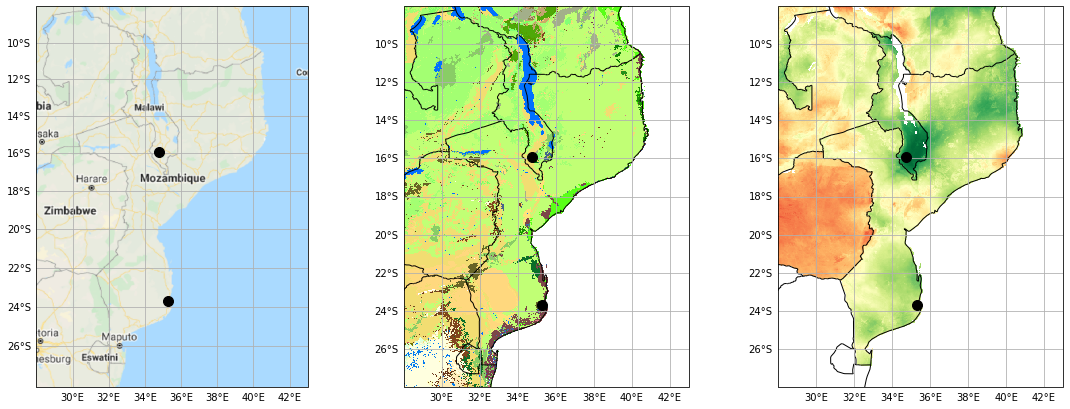

In [62]:
fig = plt.figure(figsize=(19, 7))
extent = (28, 43, -28, -8)
plot_kws = dict(marker='o', markersize=10)
ax = fig.add_subplot(1, 3, 1, projection=crs_mercator)
plot_map(extent=extent, background='google', bgzoom=5, gridlines=2, 
         plot_kws=plot_kws, ax=ax)
ax = fig.add_subplot(1, 3, 2, projection=crs_lonlat)
plot_map(extent=extent, background='ecosystems', gridlines=2, 
         plot_kws=plot_kws, ax=ax)
ax = fig.add_subplot(1, 3, 3, projection=crs_lonlat)
plot_map(extent=extent, background='itn_coverage', gridlines=2, 
         plot_kws=plot_kws, ax=ax)


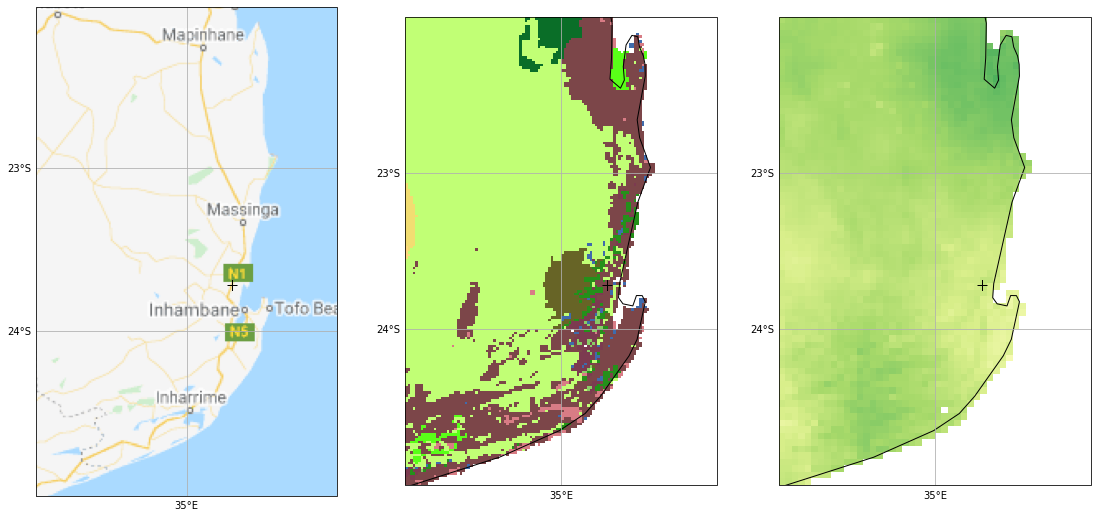

In [63]:
fig = plt.figure(figsize=(19, 9))
extent = (34, 36, -25, -22)
plot_kws = dict(marker='+', markersize=10)
ax = fig.add_subplot(1, 3, 1, projection=crs_mercator)
plot_map(extent=extent, background='google', bgzoom=7, gridlines=1, 
         plot_kws=plot_kws, ax=ax)
ax = fig.add_subplot(1, 3, 2, projection=crs_lonlat)
plot_map(extent=extent, background='ecosystems', gridlines=1, 
         plot_kws=plot_kws, ax=ax)
ax = fig.add_subplot(1, 3, 3, projection=crs_lonlat)
plot_map(extent=extent, background='itn_coverage', gridlines=1, 
         plot_kws=plot_kws, ax=ax)


In [43]:
df_samples = ag3.sample_metadata()


In [45]:
df_samples.query("country == 'Mozambique'").groupby(['location', 'year', 'species']).size()

location  year  species
Furvela   2003  gambiae     3
          2004  gambiae    71
dtype: int64

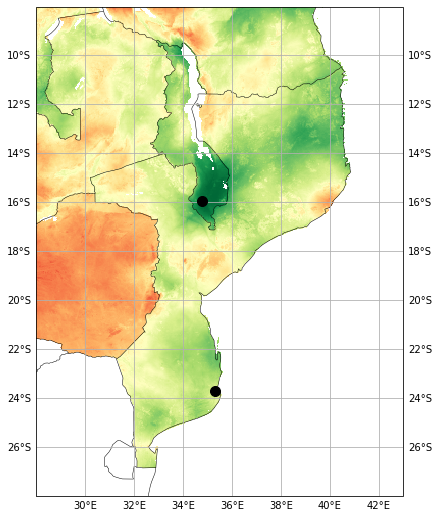

In [23]:
plot_map(extent=(28, 43, -28, -8), background='itn_coverage', gridlines=2, plot_kws=dict(marker='o', markersize=10), 
         figsize=(9, 9), projection=crs_lonlat)

sample_id partner_sample_id  ... species_gambiae_coluzzii   species
0  AR0047-C            LUA047  ...                 coluzzii  coluzzii
1  AR0049-C            LUA049  ...                 coluzzii  coluzzii
2  AR0051-C            LUA051  ...                 coluzzii  coluzzii
3  AR0061-C            LUA061  ...                 coluzzii  coluzzii
4  AR0078-C            LUA078  ...                 coluzzii  coluzzii

[5 rows x 17 columns]

In [21]:
df_samples[['country', 'location', 'latitude', 'longitude']].drop_duplicates()

country        location  latitude  longitude
0           Angola          Luanda    -8.884     13.302
81    Burkina Faso            Pala    11.150     -4.235
83    Burkina Faso            Bana    11.233     -4.472
120   Burkina Faso  Souroukoudinga    11.235     -4.535
364   Burkina Faso      Monomtenga    12.060     -1.170
...            ...             ...       ...        ...
2364      Tanzania           Moshi    -3.482     37.308
2403      Tanzania          Tarime    -1.431     34.199
2450      Tanzania          Muheza    -4.940     38.948
2494        Uganda       Nagongera     0.770     34.026
2688        Uganda          Kihihi    -0.751     29.701

[126 rows x 4 columns]

In [ ]:
itn_coverage_2019 = rasterio.open("2020_Africa_ITN_Use/2020_GBD2021_Africa_ITN_Coverage_2019.tif")
itn_coverage_2019

<open DatasetReader name='2020_Africa_ITN_Use/2020_GBD2021_Africa_ITN_Coverage_2019.tif' mode='r'>

In [ ]:
itn_coverage_2019.crs

CRS.from_epsg(4326)

In [ ]:
itn_coverage_2019.shape

(1741, 1681)

In [ ]:
itn_data = itn_coverage_2019.read(1)
#itn_data[itn_data < 0] = 0

In [ ]:
itn_data.max()

0.96953976

In [ ]:
itn_data.min()

-9999.0

In [ ]:
import numpy as np

In [ ]:
x = np.ma.masked_where(itn_data <= 0, itn_data)

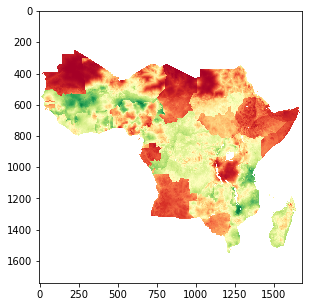

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(x, interpolation='nearest', cmap='RdYlGn', vmin=0, vmax=1, );

## African ecosystems

In [ ]:
!wget https://storage.googleapis.com/vo_agam_release/reference/af_labeled_ecosys/Africa_IVC_20130316_final_MG_5pc.tif
!wget https://storage.googleapis.com/vo_agam_release/reference/af_labeled_ecosys/Africa_IVC_20130316_final_MG.tif.vat.csv

--2021-02-22 16:47:03--  https://storage.googleapis.com/vo_agam_release/reference/af_labeled_ecosys/Africa_IVC_20130316_final_MG_5pc.tif
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.31.128, 74.125.141.128, 173.194.210.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.31.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 94643430 (90M) [image/tiff]
Saving to: ‘Africa_IVC_20130316_final_MG_5pc.tif’

Africa_IVC_20130316 100%[===================>]  90.26M   195MB/s    in 0.5s    

2021-02-22 16:47:04 (195 MB/s) - ‘Africa_IVC_20130316_final_MG_5pc.tif’ saved [94643430/94643430]

--2021-02-22 16:47:04--  https://storage.googleapis.com/vo_agam_release/reference/af_labeled_ecosys/Africa_IVC_20130316_final_MG.tif.vat.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.31.128, 173.194.214.128, 173.194.215.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.31.128|:443... co

In [ ]:
import pandas as pd
df_colors = pd.read_csv('Africa_IVC_20130316_final_MG.tif.vat.csv').set_index('Value')
df_colors.head()

Count hierarchy  ...      Blue Opacity
Value                          ...                  
0      2.730513e+09       NaN  ...  0.000000     1.0
1      3.364797e+08  1.A.2.Fd  ...  0.039216     1.0
3      3.990183e+07  1.A.2.Fd  ...  0.047059     1.0
4      3.666429e+06  1.A.2.Fd  ...  0.039216     1.0
5      1.398415e+06  1.A.2.Fe  ...  0.184314     1.0

[5 rows x 18 columns]

In [ ]:
# make a matplotlib color map
colors = np.zeros((df_colors.index.max() + 1, 3), dtype=float)
for v, (r, g, b) in df_colors[['Red', 'Green', 'Blue']].iterrows():
    colors[int(v)] = r, g, b
# fix the zero colour to be white
colors[0] = 1, 1, 1
import matplotlib as mpl
ecosystems_cmap = mpl.colors.ListedColormap(colors)

In [ ]:
!pip install fsspec gcsfs

     |████████████████████████████████| 1.3MB 6.6MB/s 
     |████████████████████████████████| 296kB 15.3MB/s 
     |████████████████████████████████| 143kB 19.0MB/s 
  Created wheel for idna-ssl: filename=idna_ssl-1.1.0-cp36-none-any.whl size=3163 sha256=840dde6c89b0cf94e3d5c266224493397f33198d79ba491c67e4378614ab2510
  Stored in directory: /root/.cache/pip/wheels/d3/00/b3/32d613e19e08a739751dd6bf998cfed277728f8b2127ad4eb7
Successfully built idna-ssl


In [ ]:
import rasterio
import fsspec

In [ ]:
with fsspec.open("gs://vo_agam_release/reference/af_labeled_ecosys/Africa_IVC_20130316_final_MG_5pc.tif") as f:
    with rasterio.open(f) as ecosystems:
        ecosystems_extent_lonlat = (
            ecosystems.bounds.left, 
            ecosystems.bounds.right,
            ecosystems.bounds.bottom,
            ecosystems.bounds.top
        )
        ecosystems_data = ecosystems.read(1)
ecosystems_data

array([[-2147483648, -2147483648, -2147483648, ..., -2147483648,
        -2147483648, -2147483648],
       [-2147483648, -2147483648, -2147483648, ..., -2147483648,
        -2147483648, -2147483648],
       [-2147483648, -2147483648, -2147483648, ..., -2147483648,
        -2147483648, -2147483648],
       ...,
       [-2147483648, -2147483648, -2147483648, ..., -2147483648,
        -2147483648, -2147483648],
       [-2147483648, -2147483648, -2147483648, ..., -2147483648,
        -2147483648, -2147483648],
       [-2147483648, -2147483648, -2147483648, ..., -2147483648,
        -2147483648, -2147483648]], dtype=int32)

In [ ]:
ecosystems.bounds

BoundingBox(left=-26.00013888888887, bottom=-34.999861108191126, right=63.99986110751114, top=38.00013888888887)

In [ ]:
ecosystems_extent_lonlat

(-26.00013888888887, 63.99986110751114, -34.999861108191126, 38.00013888888887)

In [ ]:
import rasterio
ecosystems = rasterio.open("Africa_IVC_20130316_final_MG_5pc.tif")
ecosystems

<open DatasetReader name='Africa_IVC_20130316_final_MG_5pc.tif' mode='r'>

In [ ]:
ecosystems_data = ecosystems.read(1).clip(min=0)
ecosystems_data

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)

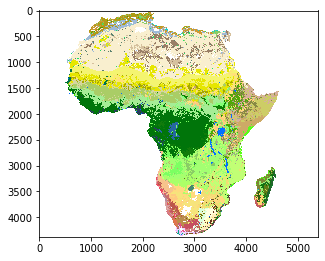

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(ecosystems_data, cmap=ecosystems_cmap, interpolation='nearest');

In [ ]:
extent_lonlat = (
    ecosystems.bounds.left, 
    ecosystems.bounds.right,
    ecosystems.bounds.bottom,
    ecosystems.bounds.top
)
extent_lonlat

(-26.00013888888887, 63.99986110751114, -34.999861108191126, 38.00013888888887)

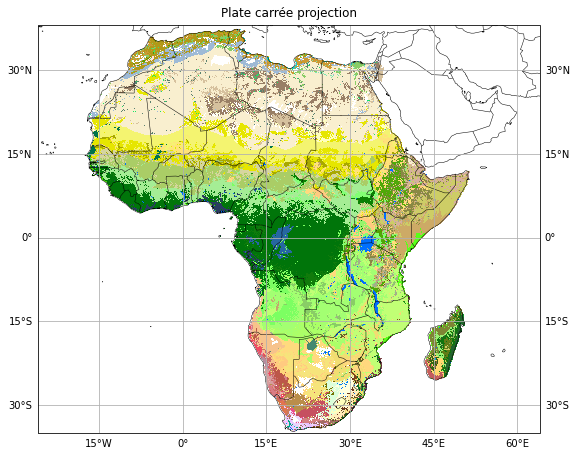

In [ ]:
crs_lonlat = ccrs.PlateCarree()
subplot_kw = dict(projection=crs_lonlat)
fig, ax = plt.subplots(figsize=(9, 9), subplot_kw=subplot_kw)
ax.set_extent(extent_lonlat, crs=crs_lonlat)
ax.imshow(ecosystems_data, cmap=ecosystems_cmap, extent=extent_lonlat, origin='upper', interpolation='nearest')
ax.coastlines(resolution='50m', linewidth=.5)
gl = ax.gridlines(crs=crs_lonlat, 
                  xlocs=np.arange(-180, 180, 15), 
                  ylocs=np.arange(-180, 180, 15), 
                  draw_labels=True)
gl.xlabels_top = None
ax.add_feature(cfeature.BORDERS, linewidth=.5)
ax.set_title('Plate carrée projection', va='bottom');

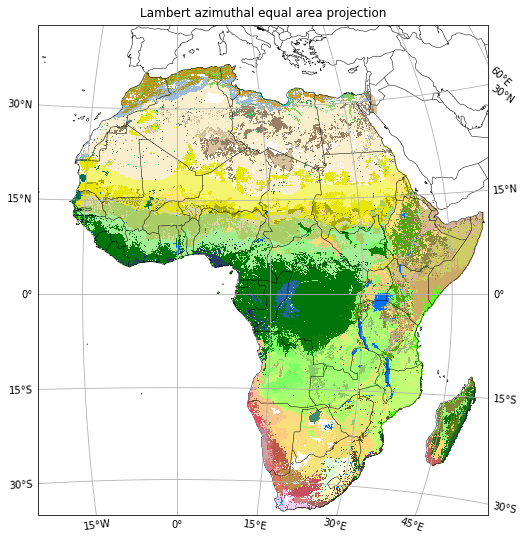

In [ ]:
crs_laea = ccrs.LambertAzimuthalEqualArea()
xmin, ymin = crs_laea.transform_point(extent_lonlat[0], extent_lonlat[2], crs_lonlat)
xmax, ymax = crs_laea.transform_point(extent_lonlat[1], extent_lonlat[3], crs_lonlat)
extent_laea = (xmin, xmax, ymin, ymax)
subplot_kw = dict(projection=crs_laea)
fig, ax = plt.subplots(figsize=(9, 9), subplot_kw=subplot_kw)
ax.set_extent(extent_laea, crs=crs_laea)
ax.imshow(ecosystems_data, cmap=ecosystems_cmap, extent=extent_lonlat, transform=crs_lonlat, origin='upper', interpolation='nearest')
ax.coastlines(resolution='50m', linewidth=.5)
gl = ax.gridlines(crs=crs_lonlat, 
                  xlocs=np.arange(-180, 180, 15), 
                  ylocs=np.arange(-180, 180, 15), 
                  draw_labels=True)
gl.xlabels_top = None
ax.add_feature(cfeature.BORDERS, linewidth=.5)
ax.set_title('Lambert azimuthal equal area projection', va='bottom');

In [ ]:

from cartopy.io.img_tiles import OSM, GoogleTiles, MapQuestOpenAerial
osm = OSM()

In [ ]:


from cartopy.io.img_tiles import GoogleTiles
goog = GoogleTiles()

In [ ]:
crs_lonlat = ccrs.PlateCarree()

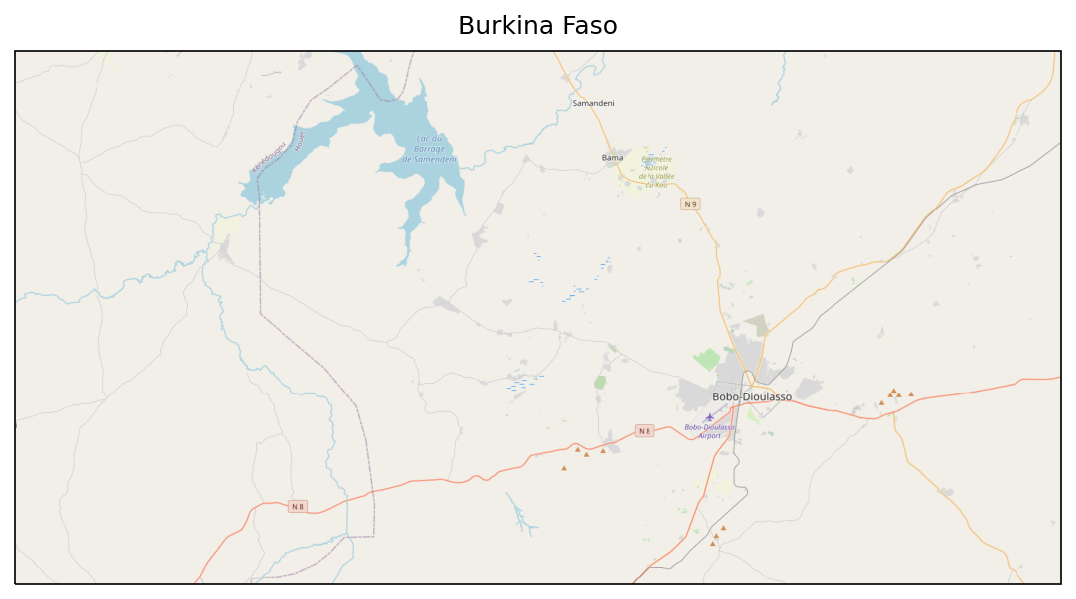

In [ ]:
extent_lonlat_bf = [-5, -4, 11, 11.5]
fig = plt.figure(figsize=(9, 9), dpi=150)
ax = fig.add_subplot(111, projection=osm.crs)
ax.set_extent(extent_lonlat_bf, crs=crs_lonlat)
ax.add_image(osm, 11)
ax.set_title('Burkina Faso', va='bottom');

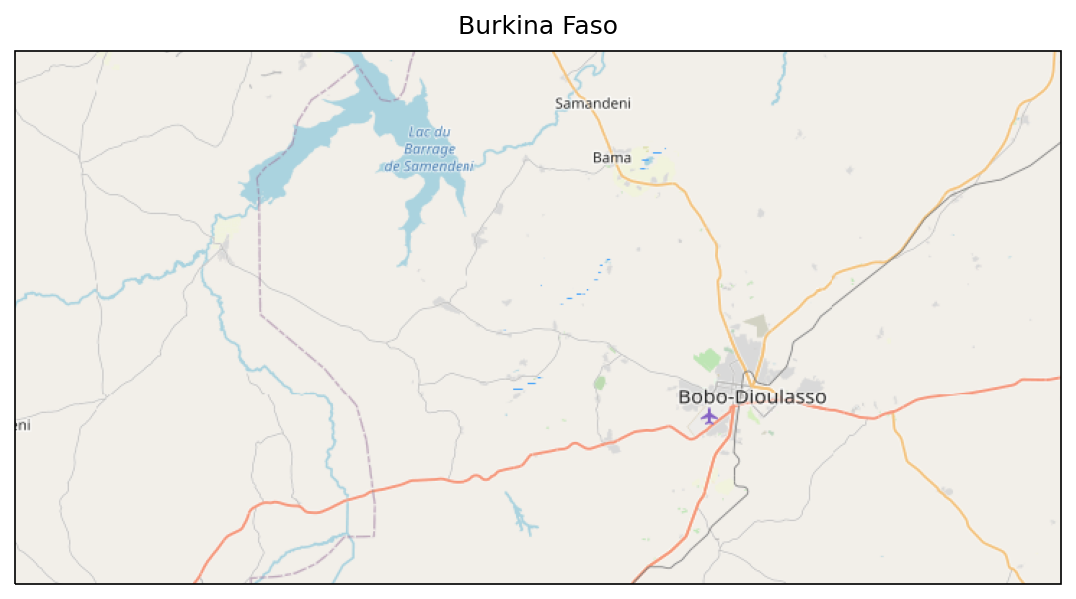

In [ ]:
extent_lonlat_bf = [-5, -4, 11, 11.5]
fig = plt.figure(figsize=(9, 9), dpi=150)
ax = fig.add_subplot(111, projection=osm.crs)
ax.set_extent(extent_lonlat_bf, crs=crs_lonlat)
ax.add_image(osm, 10)
ax.set_title('Burkina Faso', va='bottom');

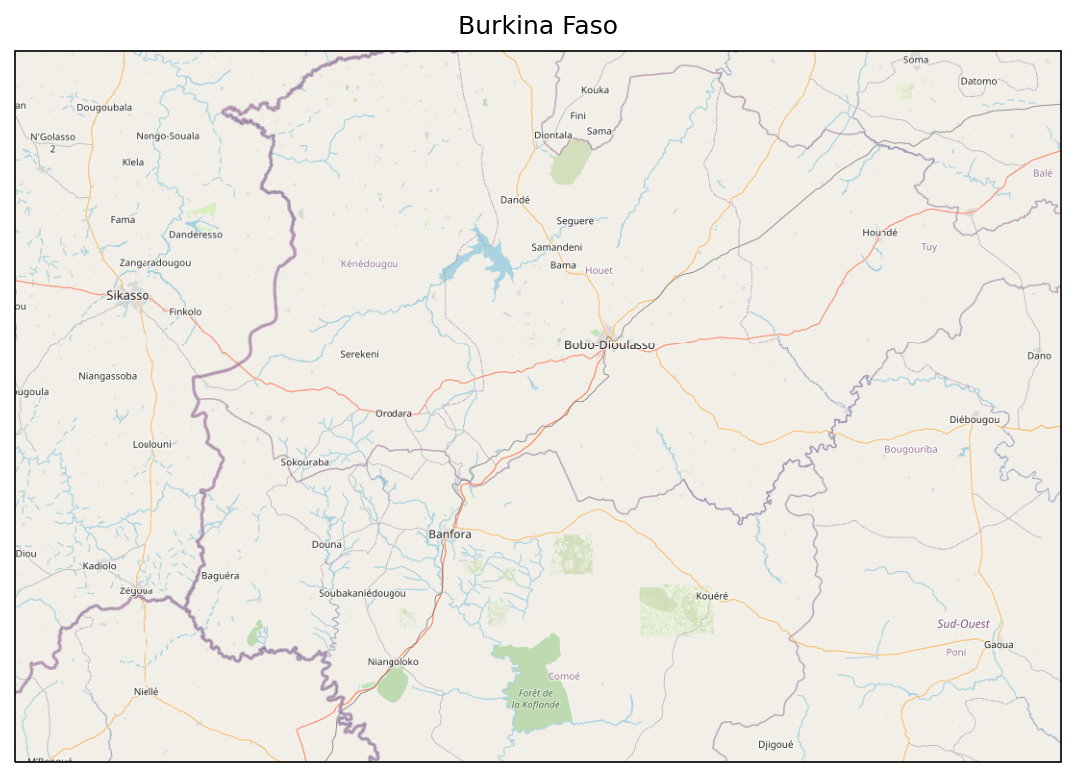

In [ ]:
extent_lonlat_bf = [-6, -3, 10, 12]
fig = plt.figure(figsize=(9, 9), dpi=150)
ax = fig.add_subplot(111, projection=osm.crs)
ax.set_extent(extent_lonlat_bf, crs=crs_lonlat)
ax.add_image(osm, 9)
ax.set_title('Burkina Faso', va='bottom');

In [ ]:
goog.crs

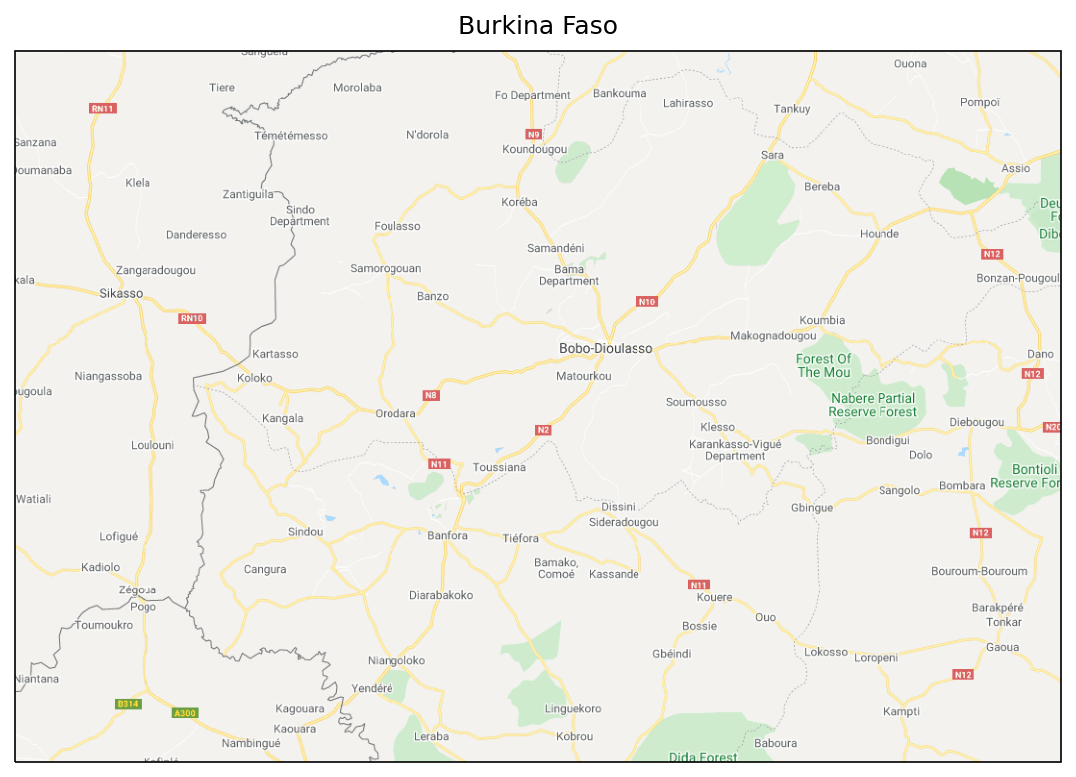

In [ ]:
extent_lonlat_bf = [-6, -3, 10, 12]
fig = plt.figure(figsize=(9, 9), dpi=150)
goog = GoogleTiles(style='street')
ax = fig.add_subplot(111, projection=goog.crs)
ax.set_extent(extent_lonlat_bf, crs=crs_lonlat)
ax.add_image(goog, 9)
ax.set_title('Burkina Faso', va='bottom');

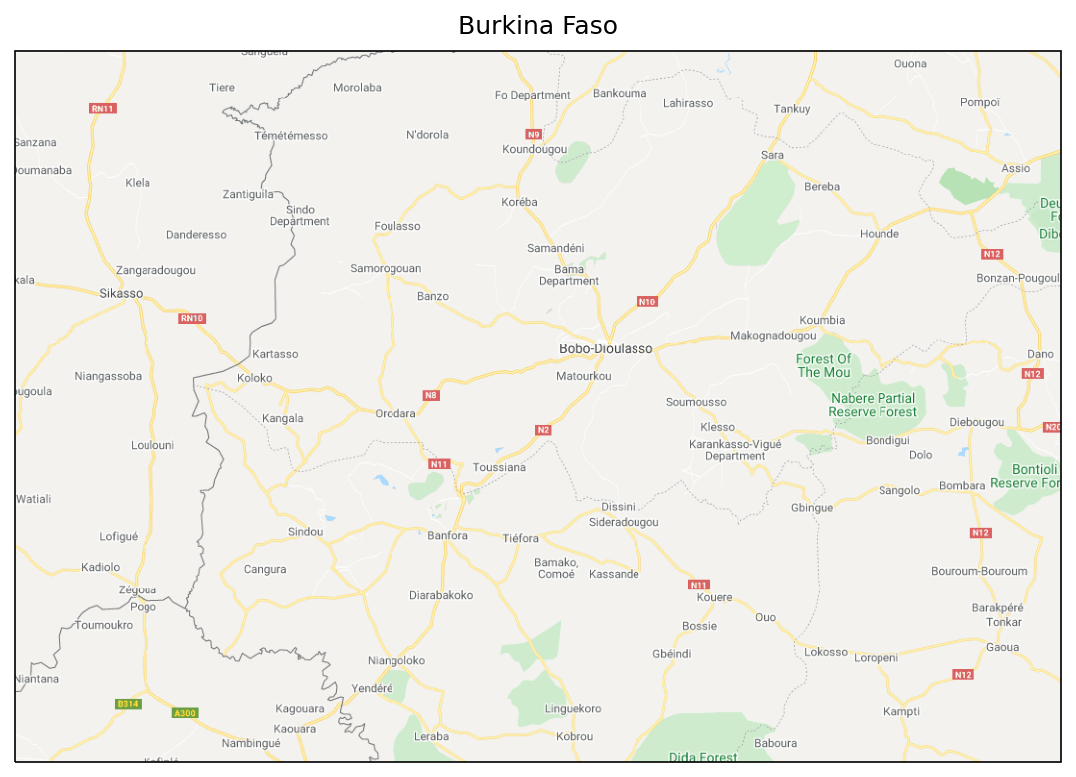

In [ ]:
extent_lonlat_bf = [-6, -3, 10, 12]
fig = plt.figure(figsize=(9, 9), dpi=150)
goog = GoogleTiles(style='street')
ax = fig.add_subplot(111, projection=goog.crs)
ax.set_extent(extent_lonlat_bf, crs=crs_lonlat)
ax.add_image(goog, 9)
ax.set_title('Burkina Faso', va='bottom');

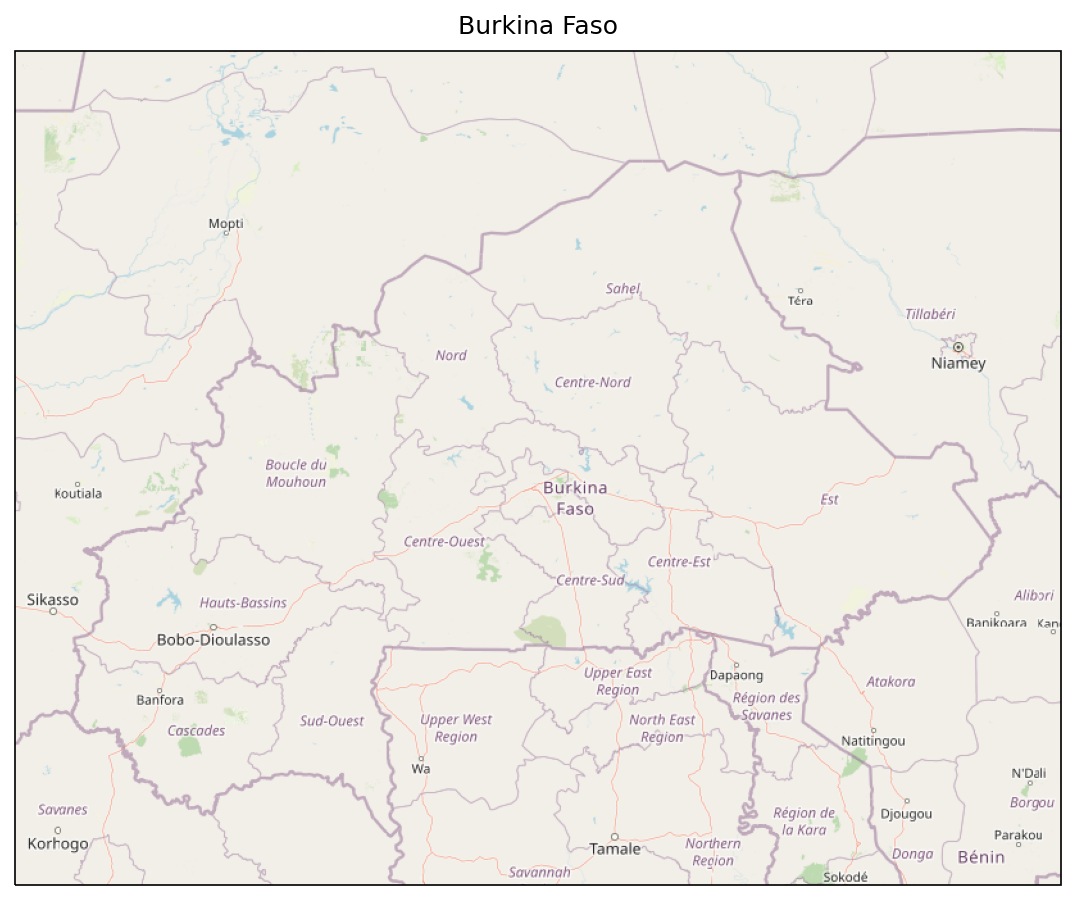

In [ ]:
extent_lonlat_bf = [-6, 3, 9, 16]
fig = plt.figure(figsize=(9, 9), dpi=150)
ax = fig.add_subplot(111, projection=osm.crs)
ax.set_extent(extent_lonlat_bf, crs=crs_lonlat)
ax.add_image(osm, 7)
ax.set_title('Burkina Faso', va='bottom');

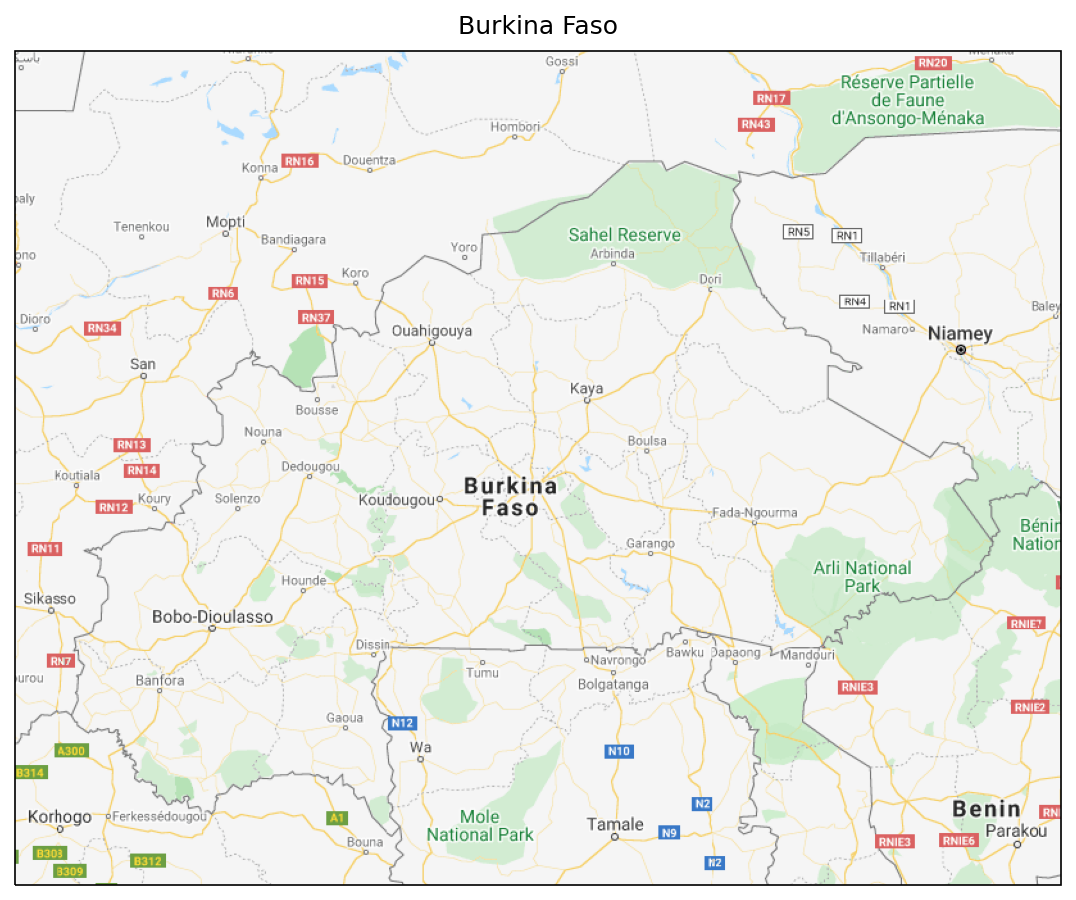

In [ ]:
extent_lonlat_bf = [-6, 3, 9, 16]
fig = plt.figure(figsize=(9, 9), dpi=150)
ax = fig.add_subplot(111, projection=goog.crs)
ax.set_extent(extent_lonlat_bf, crs=crs_lonlat)
ax.add_image(goog, 7)
ax.set_title('Burkina Faso', va='bottom');